In [2]:
%pip install psx-data-reader
%pip install scipy
%pip install bspline
from psx import stocks, tickers
import datetime
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time 
import scipy
from scipy.stats import norm
import random
import bspline
import bspline.splinelab as splinelab

#importing data for silk bank
tickers = tickers()
data = stocks("SILK", start=datetime.date(2023, 2, 1), end=datetime.date.today())

# Transforming data
df_data= data
df_data.head()

# Calculate daily return  
df_data['daily return'] = np.log(df_data['Close']) - np.log(df_data['Close'].shift(1))
df_data['volatility'] = np.sqrt(((df_data['Close'] - df_data['daily return'])/991))


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\syeda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\syeda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\syeda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
 df_data.tail()

,Open,High,Low,Close,Volume,daily return,volatility
Date,,,,,,,
2024-03-07,1.01,1.02,0.98,1.00,5626000.0,0.010050,0.031606
2024-03-08,1.02,1.02,0.99,0.99,1570500.0,-0.010050,0.031767
2024-03-11,1.01,1.02,0.99,1.00,1570000.0,0.010050,0.031606
2024-03-12,0.99,1.00,0.95,0.97,3286000.0,-0.030459,0.031773
2024-03-13,0.99,1.02,0.94,0.95,2906500.0,-0.020834,0.031299


In [4]:
drift=np.mean(df_data['daily return'])
drift

0.0001973256250739989

In [5]:
S0 = 1.0       # initial stock price
mu = 0.01005     # drift
sigma = 0.0316  # volatility
r = 0.15      # risk-free rate 10-yr yield on Pib bon
M = 1         # maturity
T = 24        # number of time steps
K = 10        #Strike price

N_MC = 10000  # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

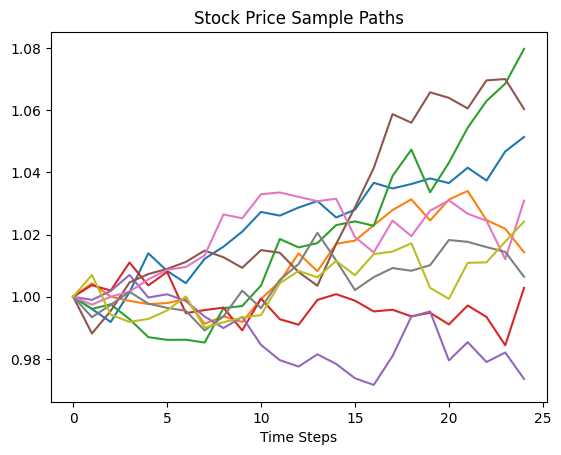

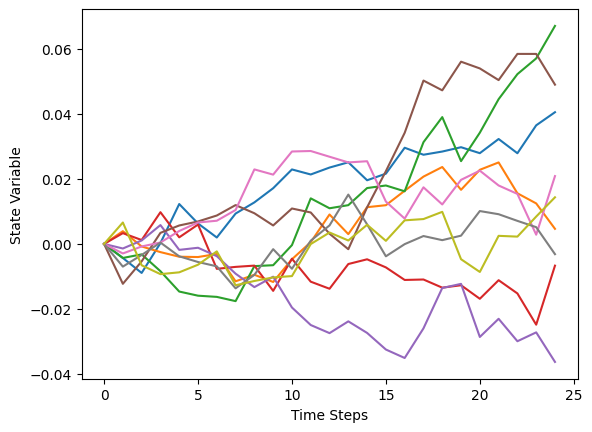

In [6]:
# make a dataset 

np.random.seed(42) # Fix random seed
# stock price
S = pd.DataFrame(data, index=range(1, N_MC+1), columns=range(T+1))  # make a data frame for values of S(stock price)
S.loc[:,0] = S0 # denote the first value of the dataframe S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1)) #generate standard normal random numbers in normal distribution

for t in range(1, T+1):
    #codify the equation for s in interval 0<s<t, Z(normal distribution) are the standard normal random numbers generated in RN
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])  

#codify the eq for delta S and delta S hat
delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable is given as
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

# plot 10 paths for both S(stock price) and X(state variable) 
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

In [7]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    if K>S0:
        payoff = max(K-ST, 0)
    else:
        payoff = max(ST-K, 0)
    return payoff

X.shape =  (10000, 25)
X_min, X_max =  -0.12223862993525143 0.12337326544581441
Number of points k =  17


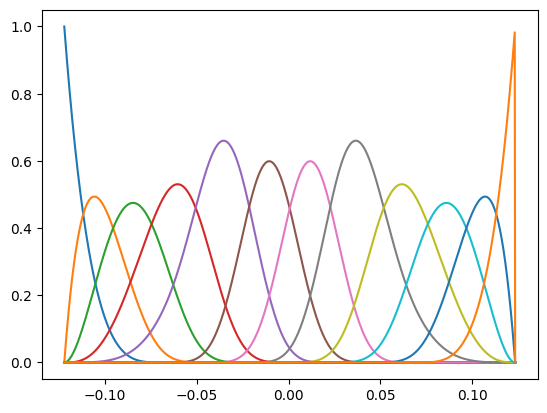

<Figure size 640x480 with 0 Axes>

In [8]:
# Build intervals for nodes from min to max nodes
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

#This corresponds to higher-order interpolation, where the curve is a sequence of polynomial segments of degree 4 or more. 
#This can produce very smooth and accurate curves, but it also requires more computation and more control points.
#It may also suffer from overfitting, oscillations, or ill-conditioning, especially for high degrees to counter that we use regulatory parameters.
p = 4         #degree of B-spline
#Number of collocation points, these points should be >=p+1,these points play a crucial role in approximating the function using B-spline basis functions.
ncolloc = 12  
#create an array of ncolloc evenly spaced numbers between X_min and X_max. This array is the set of breakpoints for the B-spline basis functions.
tau = np.linspace(X_min,X_max,ncolloc)  
#create an array of knots for the B-spline basis functions, based on the breakpoints tau and the degree p.
k = splinelab.aptknt(tau, p) 
basis = bspline.Bspline(k, p) # represents the B-spline basis functions, based on the knots k and the degree p.       
f = plt.figure()
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [9]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k)
#create an empty 3D array for basis function, where N_MC represents rows, num_basis represents columns and this 2D array is stacked upon by num_t_steps 
data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)


for i in np.arange(num_t_steps):
    x = X.values[:,i]
    #Fills the data_mat_t tensor with values computed using a basis function (denoted by basis(el)). 
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

num_basis =  12
dim data_mat_t =  (25, 10000, 12)


In [10]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(25, 10000, 12)
17


In [11]:
risk_lambda = 0.001      # risk aversion

In [12]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param): #we define the function for A matrix

    X_mat = data_mat[t, :, :] # make a state variable matrix of dimension N_MC x num_basis
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).values.reshape(-1,1) #calculate square of delta S hat
    # A regularization parameter is defined to prevent overfitting
    #np.eye creates a diagonal matrix
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs) #codify the A matrix function with defined parameters
    
    return A_mat

def function_B_vec(t,
                   Pi_hat, 
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda): #we define the function for B vector

    # coef = 1/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    coef = 0. # keep it
    
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t] # calculate the first term in the bracket in equation
    X_mat = data_mat[t, :, :]  # make a state variable matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp) #codify the B Vector function with defined parameters
  
    return B_vec

In [13]:
reg_param = 1e-3
np.random.seed(42)

#calculte A Matrix by putting calculated data in the parameters of the function we created above

A_mat = function_A_vec(T-1, delta_S_hat, data_mat_t, reg_param) 
idx_row = np.random.randint(low=0, high=A_mat.shape[0], size=50)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=A_mat.shape[1], size=50)


A_mat[idx_row, idx_col]

array([0.04826585, 0.00886837, 0.0013428 , 0.03831085, 0.03573769,
       0.04826585, 0.0024835 , 0.00235462, 0.04826585, 0.0013428 ,
       0.0013428 , 0.03831085, 0.03573769, 0.00886837, 0.03831085,
       0.03831085, 0.00235462, 0.04765751, 0.03573769, 0.00114693,
       0.03831085, 0.00105486, 0.04765751, 0.00114693, 0.00105486,
       0.03573769, 0.00117174, 0.00105486, 0.0024835 , 0.04765751,
       0.00105486, 0.01011294, 0.00117174, 0.0013428 , 0.0013428 ,
       0.0024835 , 0.00105486, 0.00105486, 0.00235462, 0.00105486,
       0.04826585, 0.00886837, 0.01011294, 0.00235462, 0.03573769,
       0.00235462, 0.04826585, 0.03573769, 0.01011294, 0.04826585])

In [14]:
np.random.seed(42)
risk_lambda = 0.001
#calculte B vector by putting calculated data in the parameters of the function we created above
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) # defined a dataframe to store values for Pi
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K)) #calculate hedge portfolio at terminal condition

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) # defined a dataframe to store values for Pi hat
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1]) #calculate pi hat
B_vec = function_B_vec(T-1, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)

B_vec

array([0.0007066654693486875, -0.0015357649050132007,
       -0.0021012063212536053, -0.008396245809679608,
       -0.06128414449767552, -0.10530631165880051, -0.1020418310446269,
       -0.06330162457695877, -0.020068016036120767, -0.005921408066568692,
       -0.0024709619127653154, -0.0012043608823640826], dtype=object)

In [15]:
# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) # make a data frame for optimal action a*
a.iloc[:,-1] = 0

reg_param = 1e-3
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    phi = np.dot(np.linalg.inv(A_mat), B_vec) #calculating phi at t by multiplying inverse of A matrix with vector B

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi) #the optimal action for the hedge portfolio
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t]) # the hedged portfolio created by optimal action 
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')

In [16]:
# The Black-Scholes prices by codifying its eq
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

In [17]:
eta = 0.005 #noise generated, it can be 0.005,0.5,0.05 
reg_param = 1e-3
np.random.seed(42) # Fix random seed

# disturbed optimal actions to be computed 
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# also make portfolios and rewards
# portfolio value
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):
    
    
    # Compute the optimal policy(which was calculated in DP approach), and write the result to a_op
    a_op.loc[:, t] = a.loc[:, t]
    # Now disturb these values by a random noise
    a_op.loc[:, t] *= np.random.uniform(1 - eta, 1 + eta, size=a_op.shape[0])
    # Compute portfolio values corresponding to observed actions    
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
    
    # Compute rewards corrresponding to observed actions
    R_op.loc[:,t] = gamma * a_op.loc[:,t] * delta_S.loc[:,t] - risk_lambda * np.var(Pi_op.loc[:,t])

R_op.loc[:,t]

1        0.000445
2        0.001564
3        0.000613
4        0.001022
5        0.000664
           ...   
9996     0.001434
9997     0.001444
9998     0.000779
9999    -0.000192
10000    0.001577
Name: 0, Length: 10000, dtype: object

In [18]:
#Generate random actions for off-policy data
np.random.seed(42)
idx_row = np.random.randint(low=0, high=R_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=R_op.shape[1], size=10)
R_op.loc[idx_row, idx_col].values.flatten()

array([0.0029754364786099188, 0.004955270667321034,
       -0.0002413350513170763, 0.011707192191026528,
       0.0011291856525965113, -0.007028465351237102,
       0.0029754364786099188, 0.0068685087031846856, 0.009012721300230165,
       0.011707192191026528, 0.004959562738365821, 0.0029397390097230247,
       -0.0030068678698670407, 0.011354673632537848, 0.005504677955621354,
       -0.0022585326316143417, 0.004959562738365821,
       -0.004168362640046572, 0.01115229017079377, 0.011354673632537848,
       -0.0003044812825537451, 0.00837026158801106, 0.006301326223857602,
       0.007728330797042504, 0.002691875867349154, 0.006010600526986514,
       -0.0003044812825537451, 0.005019206302547468,
       0.0073571608084292426, 0.007728330797042504, 0.0011292941496807386,
       0.006971637467467387, 0.005481056671266153, 0.006420775478581165,
       0.008864837827024998, 0.0003424025293181368, 0.0011292941496807386,
       0.0027997037244217086, 0.000860363444109667, 0.006420775478581

In [19]:
#Generate random actions for off-policy data
np.random.seed(42)
idx_row = np.random.randint(low=0, high=Pi_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=Pi_op.shape[1], size=10)
Pi_op.loc[idx_row, idx_col].values.flatten()

array([7.964168773722861, 8.714359366680698, 8.423636273863842,
       8.179874387745578, 8.017094852648016, 8.773981753752933,
       7.964168773722861, 8.653195314012503, 8.882648823696137,
       8.179874387745578, 7.959073827257636, 8.700732842955409,
       8.419093926414927, 8.177457005267785, 8.013964528931277,
       8.758241629377537, 7.959073827257636, 8.650690561814287,
       8.861650769190607, 8.177457005267785, 7.970577348950998,
       8.690771062200149, 8.39907512316774, 8.173508155043585,
       8.020243125458254, 8.753681962151155, 7.970577348950998,
       8.631603279084834, 8.87114342180391, 8.173508155043585,
       7.9604252979680385, 8.71213731433551, 8.416396623669154,
       8.178795757742916, 8.011470190051215, 8.773774778647557,
       7.9604252979680385, 8.65505591116405, 8.898634929225633,
       8.178795757742916, 7.961394519806819, 8.718386070141923,
       8.403329562888594, 8.174432679295679, 8.01488801421186,
       8.780012368493267, 7.961394519806819

In [20]:
# Override on-policy data with off-policy data
a = a_op.copy()      # distrubed actions
Pi = Pi_op.copy()    # disturbed portfolio values
Pi_hat = Pi_op_hat.copy()
R = R_op.copy()

In [21]:
# make matrix A_t
num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2)) #stacking up the to make a 3x1 matrix

print(A_stack.shape)

(3, 10000, 25)


In [22]:
#Swaps the first and third axes of data_mat_t.
#This operation rearranges the dimensions to align with the subsequent calculations.
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

print(data_mat_swap_idx.shape)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0) 
print('A_2',A_2.shape)
print('data_mat_swap_idx',data_mat_swap_idx.shape)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

print('Psi_mat',Psi_mat.shape)

(12, 10000, 25)
A_2 (3, 1, 10000, 25)
data_mat_swap_idx (1, 12, 10000, 25)
Psi_mat (36, 10000, 25)


In [ ]:
# make matrix S_t_mat 

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S1_t_mat = np.multiply(Psi_1_aux, Psi_2_aux)
S_t_mat = np.sum(S1_t_mat, axis=2) 
print(S1_t_mat.shape)
print(S_t_mat.shape)

In [ ]:
# clean up some space
del Psi_1_aux, Psi_2_aux, data_mat_swap_idx, A_2

In [ ]:
#calculate st and mt matrix
def function_S_vec(t, S_t_mat, reg_param):
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param * np.eye(num_Qbasis)

    return S_mat_reg
   
def function_M_vec(t,
                   Q_star, 
                   R, 
                   Psi_mat_t, 
                   gamma=gamma):
    
    M_t = np.dot(Psi_mat_t, R.loc[:,t] + gamma * Q_star.loc[:, t+1])

    return M_t

In [ ]:
reg_param = 1e-3
np.random.seed(42)
S_mat_reg = function_S_vec(T-1, S_t_mat, reg_param) 
idx_row = np.random.randint(low=0, high=S_mat_reg.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=S_mat_reg.shape[1], size=10)

S_mat_reg[idx_row, idx_col].flatten().astype(float)

In [ ]:
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

M_t = function_M_vec(T-1, Q_star, R, Psi_mat[:,:,T-1], gamma)
M_t = M_t.astype(float)

M_t

In [ ]:
# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]
 
max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

# The backward loop
for t in range(T-1, -1, -1):
    
    # calculate vector W_t
    S_mat_reg = function_S_vec(t, S_t_mat, reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    S_mat_reg_inv= np.linalg.inv(S_mat_reg.astype(float))
    W_t = np.dot(S_mat_reg_inv,M_t) 
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  
        
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T 

    # compute matrix U_mat
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]
 
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 

    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    
    # update dataframes     
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    Psi_t = Psi_mat[:,:,t].T 
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 
    low_percentile_Q_RL = 5 
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL


In [ ]:
# plot both simulations
f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()

In [ ]:
# plot a and a_star
num_path =  120

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()

In [ ]:
# QLBS option price
C_QLBS = - Q_star.iloc[:,24] # Q_RL # 

print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nThe QLBS Put Price 1 :', (np.mean(C_QLBS))))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_put(0)))
print('\n')


In [ ]:
C_QRL = - Q_RL.iloc[:,24] # Q_RL
print((np.mean(C_QRL)))